<a href="https://colab.research.google.com/github/GaikwadSandesh/Coronavirus-Tweet-Sentiment-Analysis/blob/main/Coronavirus_Tweet_Sentiment_Analysis_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sentiment Analysis : Predicting sentiment of COVID-19 tweets</u></b>

## <b> Problem Description </b>

### This challenge asks you to build a classification model to predict the sentiment of COVID-19 tweets.The tweets have been pulled from Twitter and manual tagging has been done then.

### The names and usernames have been given codes to avoid any privacy concerns.

### You are given the following information:
1. Location
2. Tweet At
3. Original Tweet
4. Label

# Data loading and Cleaning

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report,confusion_matrix , accuracy_score
from sklearn.model_selection import GridSearchCV
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Alma_better/Twitter sentiments/Coronavirus Tweets.csv' ,encoding='latin-1')

In [ ]:
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

UserName and ScreenName columns are irrelevent for our Generlised analysis

In [ ]:
df.drop(columns=['ScreenName' ,'UserName']  , inplace=True)

In [ ]:
df.head()

,Location,TweetAt,OriginalTweet,Sentiment
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Location       32567 non-null  object
 1   TweetAt        41157 non-null  object
 2   OriginalTweet  41157 non-null  object
 3   Sentiment      41157 non-null  object
dtypes: object(4)
memory usage: 1.3+ MB


In [ ]:
df.isnull().sum()

Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [ ]:
print(round(100*(df.isnull().sum()/len(df.index)),2))

Location         20.87
TweetAt           0.00
OriginalTweet     0.00
Sentiment         0.00
dtype: float64


In [ ]:
#df.dropna()['Location'].value_counts().to_frame().head(25)

In [ ]:
df.drop(columns=['Location' ,'TweetAt'] , inplace=True)

# EDA

In [ ]:
pd.concat([df.head(3), df.tail(3)], axis=0)

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
41154,You know itÂs getting tough when @KameronWild...,Positive
41155,Is it wrong that the smell of hand sanitizer i...,Neutral
41156,@TartiiCat Well new/used Rift S are going for ...,Negative


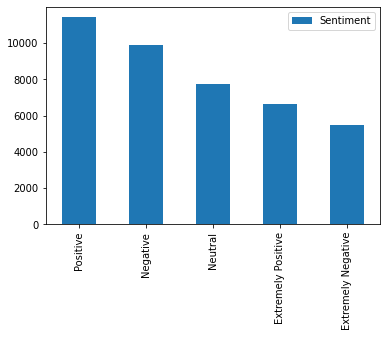

In [ ]:
df['Sentiment'].value_counts().to_frame().plot(kind = 'bar')

We will ony consider tweet column and use NLP based approch to build classifier

Preprocessing of tweets column

In [ ]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [ ]:
import nltk
nltk.download('stopwords')
sw = stopwords.words('english') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [ ]:
def seniment_encoding(Sentiment):
  value = 0
  if Sentiment == 'Extremely Negative':
    value = -4 
  elif Sentiment == 'Negative':
    value = -1 
  elif   Sentiment == 'Extremely Positive':   
    value = 4
  elif Sentiment == 'Positive':
    value = 1
  else:
      pass
  return value
  

In [ ]:
df.Sentiment.unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [ ]:
df['filtered'] = df['OriginalTweet'].apply(remove_punctuation)

In [ ]:
df['filtered'] = df['filtered'].apply(stopwords)

In [ ]:
df['encode_senti'] =  df['Sentiment'].apply(seniment_encoding)

In [ ]:
df




,OriginalTweet,Sentiment,filtered,encode_senti
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,menyrbie philgahan chrisitv httpstcoifz9fan2pa...,0
1,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,1
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,1
3,My food stock is not the only one which is emp...,Positive,food stock one empty please dont panic enough ...,1
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready go supermarket covid19 outbreak im paran...,-4
5,As news of the regionÂs first confirmed COVID...,Positive,news regionâs first confirmed covid19 case ca...,1
6,Cashier at grocery store was sharing his insig...,Positive,cashier grocery store sharing insights covid19...,1
7,Was at the supermarket today. Didn't buy toile...,Neutral,supermarket today didnt buy toilet paper rebel...,0
8,Due to COVID-19 our retail store and classroom...,Positive,due covid19 retail store classroom atlanta ope...,1
9,"For corona prevention,we should stop to buy th...",Negative,corona preventionwe stop buy things cash use o...,-1


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df['filtered'] , df['encode_senti'],test_size=0.2 , random_state=42)

In [ ]:
def evaluation_metrics(y_train , y_train_p ,y_test, y_test_p):
  MSE_train  = round(mean_squared_error(y_test, y_test_p), 2)
  print("MSE train:" , MSE_train)
  MSE_test  = round(mean_squared_error(y_train, y_train_p), 2)
  print("MSE test:" , MSE_test)

  RMSE_train = round(np.sqrt(MSE_train), 2)
  print("RMSE train:" ,RMSE_train)
  RMSE_test = round(np.sqrt(MSE_test), 2)
  print("RMSE test:" ,RMSE_test)


  print("classification report train data")
  print(classification_report(y_train,y_train_p))
  print("\n")
  print("classification report test data")
  print(classification_report(y_test,y_test_p))

  print("Training accuracy Score   : ",accuracy_score(y_train,y_train_p))
  print("Validation accuracy Score : ",accuracy_score(y_test, y_test_p))
  
  print("\n")

  labels = {-4 :'Extremely Negative', -1:'Negative', 0:'Neutral' , 1:'Positive',
       4 :'Extremely Positive'}
  confusion_matrix = metrics.confusion_matrix(y_test, y_test_p  , labels = [-4 , -1 , 0 , 1 , 4])
  sns.heatmap(confusion_matrix, annot=True, fmt="d" , xticklabels=labels , yticklabels=labels)

  plt.xlabel("Predicted Label", fontsize= 12)
  plt.ylabel("True Label", fontsize= 12)

  plt.show()



## Vectoriser

In [ ]:
# create a count vectorizer object
count_vectorizer = CountVectorizer(max_df =0.9 , min_df = 10)
# fit the count vectorizer using the text data
count_vectorizer.fit(X_train)

CountVectorizer(max_df=0.9, min_df=10)

In [ ]:
train_cv_vectorized = count_vectorizer.transform(X_train)
test_cv_vectorized = count_vectorizer.transform(X_test)
train_cv_array= train_cv_vectorized.toarray()
test_cv_array = test_cv_vectorized.toarray()

In [ ]:
train_cv_array.shape

(32925, 5907)

In [ ]:
# create a count vectorizer object
Tfidf_vectorizer = TfidfVectorizer(max_df =0.9, min_df = 10)
# fit the count vectorizer using the text data
Tfidf_vectorizer.fit(X_train)

TfidfVectorizer(max_df=0.9, min_df=10)

In [ ]:
train_tfidf_vectorized = Tfidf_vectorizer.transform(X_train)
test_tfidf_vectorized = Tfidf_vectorizer.transform(X_test)
train_tfidf_array= train_tfidf_vectorized.toarray()
test_tfidf_array = test_tfidf_vectorized.toarray()

In [ ]:
train_tfidf_array.shape

(32925, 5907)

## Naive bayes Count Vectoriser

In [ ]:
from sklearn.naive_bayes import MultinomialNB
NBC_model = MultinomialNB().fit(train_cv_array,y_train)

In [ ]:
train_preds = NBC_model.predict(train_cv_array)
test_preds = NBC_model.predict(test_cv_array)

MSE train: 4.21
MSE test: 3.11
RMSE train: 2.05
RMSE test: 1.76
classification report train data
              precision    recall  f1-score   support

          -4       0.66      0.69      0.68      4425
          -1       0.60      0.58      0.59      7911
           0       0.66      0.69      0.68      6160
           1       0.62      0.58      0.60      9135
           4       0.66      0.70      0.68      5294

    accuracy                           0.64     32925
   macro avg       0.64      0.65      0.65     32925
weighted avg       0.64      0.64      0.64     32925



classification report test data
              precision    recall  f1-score   support

          -4       0.49      0.50      0.50      1056
          -1       0.43      0.43      0.43      2006
           0       0.56      0.57      0.57      1553
           1       0.46      0.44      0.45      2287
           4       0.53      0.57      0.55      1330

    accuracy                           0.49      8232


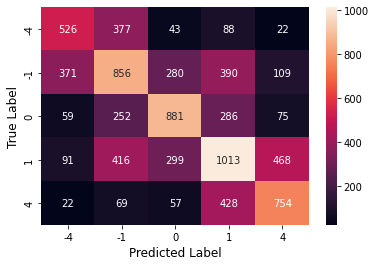

In [ ]:
evaluation_metrics(y_train, train_preds , y_test , test_preds)

# Naive Baye TFidf vectoriser 

In [ ]:
NBT_model = MultinomialNB().fit(train_tfidf_array,y_train)

In [ ]:
train_preds = NBT_model.predict(train_tfidf_array)
test_preds = NBT_model.predict(test_tfidf_array)

MSE train: 3.65
MSE test: 2.98
RMSE train: 1.91
RMSE test: 1.73
classification report train data
              precision    recall  f1-score   support

          -4       0.88      0.31      0.46      4425
          -1       0.54      0.67      0.60      7911
           0       0.77      0.52      0.62      6160
           1       0.50      0.82      0.62      9135
           4       0.85      0.37      0.52      5294

    accuracy                           0.59     32925
   macro avg       0.70      0.54      0.56     32925
weighted avg       0.66      0.59      0.58     32925



classification report test data
              precision    recall  f1-score   support

          -4       0.68      0.18      0.29      1056
          -1       0.42      0.52      0.47      2006
           0       0.64      0.37      0.47      1553
           1       0.40      0.72      0.52      2287
           4       0.67      0.25      0.36      1330

    accuracy                           0.46      8232


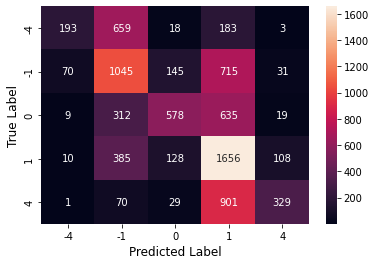

In [ ]:
evaluation_metrics(y_train, train_preds, y_test, test_preds)

# Random forest Classifier (tfidf_vectorizer)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()


In [ ]:
# Create the random grid
# param_grid = {'n_estimators': [15],
#                'max_depth': [ 50 , 80],
#                'min_samples_split': [6 ],
#                'min_samples_leaf': [4 ,6 ]}
param_grid = {'n_estimators': [15],
               'max_depth': [ 80],
               'min_samples_split': [6 ],
               'min_samples_leaf': [4 ]}

In [ ]:
grid_rf_clf = GridSearchCV(rf_clf, param_grid, cv=5)

In [ ]:
grid_rf_clf.fit(train_tfidf_array,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [80], 'min_samples_leaf': [4],
                         'min_samples_split': [6], 'n_estimators': [15]})

In [ ]:
grid_rf_clf.best_params_

{'max_depth': 80,
 'min_samples_leaf': 4,
 'min_samples_split': 6,
 'n_estimators': 15}

In [ ]:
train_preds = grid_rf_clf.predict(train_tfidf_array)
test_preds = grid_rf_clf.predict(test_tfidf_array)

MSE train: 4.04
MSE test: 3.11
RMSE train: 2.01
RMSE test: 1.76
classification report train data
              precision    recall  f1-score   support

          -4       0.74      0.50      0.60      4425
          -1       0.60      0.55      0.58      7911
           0       0.61      0.61      0.61      6160
           1       0.52      0.73      0.61      9135
           4       0.77      0.53      0.63      5294

    accuracy                           0.60     32925
   macro avg       0.65      0.59      0.60     32925
weighted avg       0.63      0.60      0.60     32925



classification report test data
              precision    recall  f1-score   support

          -4       0.58      0.37      0.45      1056
          -1       0.44      0.39      0.42      2006
           0       0.54      0.53      0.54      1553
           1       0.41      0.60      0.49      2287
           4       0.60      0.38      0.46      1330

    accuracy                           0.47      8232


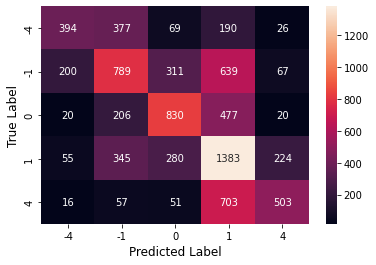

In [ ]:
evaluation_metrics(y_train, train_preds, y_test, test_preds)

# catboost

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
# we will agin split the data to get validation set
X_train_c, X_eval,y_train_c,y_eval = train_test_split(train_tfidf_array , y_train,test_size=0.1 , random_state=42)

In [ ]:
cb_clf= CatBoostClassifier()

In [ ]:
cb_clf.fit(X_train_c, y_train_c,  
        eval_set=(X_eval, y_eval), 
        verbose=False
)

In [ ]:
train_preds = cb_clf.predict(train_tfidf_array)
test_preds = cb_clf.predict(test_tfidf_array)

MSE train: 2.92
MSE test: 2.42
RMSE train: 1.71
RMSE test: 1.56
classification report train data
              precision    recall  f1-score   support

          -4       0.75      0.58      0.66      4425
          -1       0.64      0.61      0.62      7911
           0       0.65      0.81      0.72      6160
           1       0.62      0.70      0.66      9135
           4       0.79      0.60      0.69      5294

    accuracy                           0.67     32925
   macro avg       0.69      0.66      0.67     32925
weighted avg       0.68      0.67      0.67     32925



classification report test data
              precision    recall  f1-score   support

          -4       0.64      0.49      0.55      1056
          -1       0.55      0.50      0.53      2006
           0       0.61      0.78      0.68      1553
           1       0.56      0.64      0.60      2287
           4       0.73      0.54      0.62      1330

    accuracy                           0.60      8232


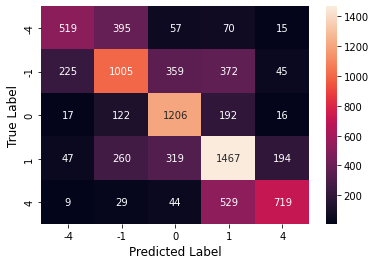

In [ ]:
evaluation_metrics(y_train, train_preds, y_test, test_preds)

In [ ]:
with open('catboost_model' , 'wb') as f:
  pickle.dump(cb_clf,f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Alma_better/Twitter sentiments/catboost_model' , 'rb') as f:
  catboost_model = pickle.load(f)

In [ ]:
train_preds = catboost_model.predict(train_tfidf_array)
test_preds = catboost_model.predict(test_tfidf_array)

MSE train: 2.92
MSE test: 2.42
RMSE train: 1.71
RMSE test: 1.56
classification report train data
              precision    recall  f1-score   support

          -4       0.75      0.58      0.66      4425
          -1       0.64      0.61      0.62      7911
           0       0.65      0.81      0.72      6160
           1       0.62      0.70      0.66      9135
           4       0.79      0.60      0.69      5294

    accuracy                           0.67     32925
   macro avg       0.69      0.66      0.67     32925
weighted avg       0.68      0.67      0.67     32925



classification report test data
              precision    recall  f1-score   support

          -4       0.64      0.49      0.55      1056
          -1       0.55      0.50      0.53      2006
           0       0.61      0.78      0.68      1553
           1       0.56      0.64      0.60      2287
           4       0.73      0.54      0.62      1330

    accuracy                           0.60      8232


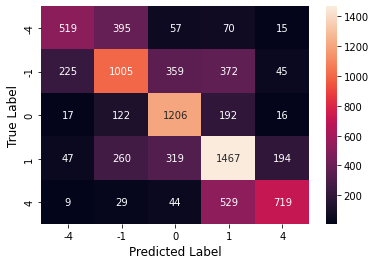

In [ ]:
evaluation_metrics(y_train, train_preds, y_test, test_preds)

# svm

In [ ]:
from sklearn.svm import SVC

svc = SVC()

In [ ]:
svc.fit(train_tfidf_array,y_train)

In [ ]:
train_preds = svc.predict(train_cv_array)
test_preds = svc.predict(test_cv_array)

In [ ]:
evaluation_metrics(y_train, train_preds , y_test , test_preds)